In [1]:
# Email Spam Detection with Word2Vec from Scratch
# ======================================
# This notebook builds a spam detection model using Word2Vec embeddings
# with a neural network classifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# For neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For Word2Vec
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# For text processing
import nltk
from nltk.corpus import stopwords

# 1. Download and extract the dataset
!wget -nc https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip
!unzip -o enron_spam_data.zip

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

--2025-03-08 04:41:05--  https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MWiechmann/enron_spam_data/master/enron_spam_data.zip [following]
--2025-03-08 04:41:06--  https://raw.githubusercontent.com/MWiechmann/enron_spam_data/master/enron_spam_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15642124 (15M) [application/zip]
Saving to: ‘enron_spam_data.zip’

enron_spam_data.zip 100%[===================>]  14.92M  77.6MB/s    in 0.2s    

2025-03-08 04:41:06 (77.6 MB/s) - ‘enron_spam_data.zip’ saved [15642124/15642

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# 2. Load the CSV file
df = pd.read_csv('enron_spam_data.csv')

In [3]:
# 3. Display dataset information
print(f"Total emails: {len(df)}")
print(f"Column names: {df.columns.tolist()}")

# Print the first few rows to understand the data structure
print("\nFirst few rows of the dataset:")
print(df.head(2))

Total emails: 33716
Column names: ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date']

First few rows of the dataset:
   Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  


In [4]:
# 4. Check for label column and convert to binary
if 'Spam/Ham' in df.columns:
    # Convert Spam/Ham labels to binary (1 for spam, 0 for ham)
    df['label'] = df['Spam/Ham'].apply(lambda x: 1 if x.lower() == 'spam' else 0)
else:
    # Look for other potential label columns
    potential_label_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['spam', 'ham', 'label', 'class'])]
    if potential_label_cols:
        print(f"Potential label columns found: {potential_label_cols}")
        # Use the first potential column
        df['label'] = df[potential_label_cols[0]].apply(lambda x: 1 if str(x).lower() == 'spam' else 0)
    else:
        raise ValueError("Couldn't identify label column in the dataset")

In [5]:
# 5. Combine Subject and Message for better feature representation
df['text'] = "Subject: " + df['Subject'].fillna('') + " " + df['Message'].fillna('')

# Print dataset distribution
print(f"Spam emails: {sum(df['label'])}")
print(f"Ham emails: {len(df) - sum(df['label'])}")
print(f"Spam ratio: {sum(df['label'])/len(df):.2f}")

# Check if text column was correctly assigned
print("\nSample text column entries:")
print(df['text'].head(2).tolist())

# Display sample emails
print("\nSample SPAM email:")
spam_sample = df[df['label'] == 1]['text'].iloc[0]
print(spam_sample[:500] + "..." if len(str(spam_sample)) > 500 else spam_sample)

print("\nSample HAM email:")
ham_sample = df[df['label'] == 0]['text'].iloc[0]
print(ham_sample[:500] + "..." if len(str(ham_sample)) > 500 else ham_sample)

Spam emails: 17171
Ham emails: 16545
Spam ratio: 0.51

Sample text column entries:
['Subject: christmas tree farm pictures ', 'Subject: vastar resources , inc . gary , production from the high island larger block a - 1 # 2 commenced on\nsaturday at 2 : 00 p . m . at about 6 , 500 gross . carlos expects between 9 , 500 and\n10 , 000 gross for tomorrow . vastar owns 68 % of the gross production .\ngeorge x 3 - 6992\n- - - - - - - - - - - - - - - - - - - - - - forwarded by george weissman / hou / ect on 12 / 13 / 99 10 : 16\nam - - - - - - - - - - - - - - - - - - - - - - - - - - -\ndaren j farmer\n12 / 10 / 99 10 : 38 am\nto : carlos j rodriguez / hou / ect @ ect\ncc : george weissman / hou / ect @ ect , melissa graves / hou / ect @ ect\nsubject : vastar resources , inc .\ncarlos ,\nplease call linda and get everything set up .\ni \' m going to estimate 4 , 500 coming up tomorrow , with a 2 , 000 increase each\nfollowing day based on my conversations with bill fischer at bmar .\nd .\n- - 

In [6]:
# 6. Text Preprocessing for Word2Vec
def preprocess_text(text):
    """
    Clean and tokenize text for Word2Vec model
    """
    if pd.isna(text):
        return []

    # Convert to string and lowercase
    text = str(text).lower()

    # Tokenize, remove stopwords and short words
    stop_words = set(stopwords.words('english'))
    tokens = simple_preprocess(text)
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    return tokens

# Apply preprocessing to all texts
df['tokens'] = df['text'].apply(preprocess_text)

# Check a tokenized example
print("\nExample of tokenized text:")
print(df['tokens'].iloc[0][:50])  # Show first 50 tokens


Example of tokenized text:
['subject', 'christmas', 'tree', 'farm', 'pictures']


In [7]:
# 7. Split data before training Word2Vec (to avoid data leakage)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 24274
Validation set size: 2698
Test set size: 6744


In [8]:
# 8. Train Word2Vec model on training data only
print("\nTraining Word2Vec model...")
EMBEDDING_DIM = 100
w2v_model = Word2Vec(sentences=train_df['tokens'],
                     vector_size=EMBEDDING_DIM,
                     window=5,
                     min_count=2,  # Ignore words that appear less than twice
                     workers=4,    # Use 4 threads for training
                     sg=1)         # Use skip-gram model

# Save the model for later use
w2v_model.save("word2vec_email.model")

# Show vocabulary size and sample vectors
print(f"Word2Vec vocabulary size: {len(w2v_model.wv.key_to_index)}")
print("\nSample word vectors:")
sample_word = list(w2v_model.wv.key_to_index.keys())[10]  # Get a sample word
print(f"Vector for '{sample_word}': {w2v_model.wv[sample_word][:5]}...")  # Show first 5 dimensions


Training Word2Vec model...
Word2Vec vocabulary size: 68604

Sample word vectors:
Vector for 'information': [ 0.41624716  0.5279001   0.13548495 -0.44301033 -0.9751537 ]...


In [9]:
# 9. Function to create document vectors from Word2Vec
def document_vector(word_list, model, vector_size=100):
    """
    Create a document vector by averaging word vectors.
    Zero vector is returned if no words in the document are in the model.
    """
    doc_vector = np.zeros(vector_size)
    valid_words = 0

    for word in word_list:
        if word in model.wv:
            valid_words += 1
            doc_vector += model.wv[word]

    if valid_words > 0:
        doc_vector /= valid_words

    return doc_vector

In [10]:
# 10. Create document vectors for train, validation, and test sets
print("\nCreating document vectors...")
X_train = np.array([document_vector(tokens, w2v_model, EMBEDDING_DIM) for tokens in train_df['tokens']])
X_val = np.array([document_vector(tokens, w2v_model, EMBEDDING_DIM) for tokens in val_df['tokens']])
X_test = np.array([document_vector(tokens, w2v_model, EMBEDDING_DIM) for tokens in test_df['tokens']])

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

print(f"Document vector shape: {X_train.shape}")


Creating document vectors...
Document vector shape: (24274, 100)


In [11]:
# 11. Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

In [12]:
# 12. Create data loaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [14]:
# 13. Define a neural network classifier for Word2Vec vectors
class Word2VecClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], output_dim=2, dropout_rate=0.3):
        super(Word2VecClassifier, self).__init__()

        # Build layers dynamically based on hidden_dims
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        # Combine all layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [15]:
# 14. Initialize model and training parameters
model = Word2VecClassifier(input_dim=EMBEDDING_DIM)
print(model)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

Word2VecClassifier(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)
The model has 21,698 trainable parameters


In [16]:
# 15. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay for regularization

In [17]:
# 16. Training function
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()

    epoch_loss = 0
    epoch_acc = 0

    for batch in dataloader:
        # Get batch data
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and update
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predictions = torch.max(outputs, 1)
        correct = (predictions == labels).float().sum()
        accuracy = correct / len(labels)

        # Update epoch metrics
        epoch_loss += loss.item() * inputs.size(0)
        epoch_acc += accuracy.item() * inputs.size(0)

    # Return average metrics
    return epoch_loss / len(dataloader.dataset), epoch_acc / len(dataloader.dataset)

In [18]:
# 17. Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in dataloader:
            # Get batch data
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Calculate accuracy
            _, predictions = torch.max(outputs, 1)
            correct = (predictions == labels).float().sum()
            accuracy = correct / len(labels)

            # Update epoch metrics
            epoch_loss += loss.item() * inputs.size(0)
            epoch_acc += accuracy.item() * inputs.size(0)

    # Return average metrics
    return epoch_loss / len(dataloader.dataset), epoch_acc / len(dataloader.dataset)

In [19]:
# 18. Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

N_EPOCHS = 20  # More epochs as this model might need more time to converge
best_valid_acc = 0

# For plotting results
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

# Create a nice-looking progress bar
from tqdm.notebook import tqdm

print("Starting training...")
for epoch in tqdm(range(N_EPOCHS)):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), 'best-word2vec-model.pt')

    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {val_loss:.4f} | Val. Acc: {val_acc*100:.2f}%')

Using device: cpu
Starting training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
	Train Loss: 0.0858 | Train Acc: 97.12%
	Val. Loss: 0.0761 | Val. Acc: 97.37%
Epoch: 2
	Train Loss: 0.0628 | Train Acc: 97.84%
	Val. Loss: 0.0453 | Val. Acc: 98.26%
Epoch: 3
	Train Loss: 0.0587 | Train Acc: 98.06%
	Val. Loss: 0.0451 | Val. Acc: 98.41%
Epoch: 4
	Train Loss: 0.0547 | Train Acc: 98.21%
	Val. Loss: 0.0423 | Val. Acc: 98.52%
Epoch: 5
	Train Loss: 0.0547 | Train Acc: 98.12%
	Val. Loss: 0.0423 | Val. Acc: 98.55%
Epoch: 6
	Train Loss: 0.0517 | Train Acc: 98.20%
	Val. Loss: 0.0400 | Val. Acc: 98.63%
Epoch: 7
	Train Loss: 0.0499 | Train Acc: 98.33%
	Val. Loss: 0.0443 | Val. Acc: 98.37%
Epoch: 8
	Train Loss: 0.0488 | Train Acc: 98.38%
	Val. Loss: 0.0390 | Val. Acc: 98.70%
Epoch: 9
	Train Loss: 0.0480 | Train Acc: 98.29%
	Val. Loss: 0.0422 | Val. Acc: 98.55%
Epoch: 10
	Train Loss: 0.0475 | Train Acc: 98.29%
	Val. Loss: 0.0716 | Val. Acc: 97.29%
Epoch: 11
	Train Loss: 0.0452 | Train Acc: 98.46%
	Val. Loss: 0.0417 | Val. Acc: 98.59%
Epoch: 12
	Train Loss: 0.0438 | Train Acc

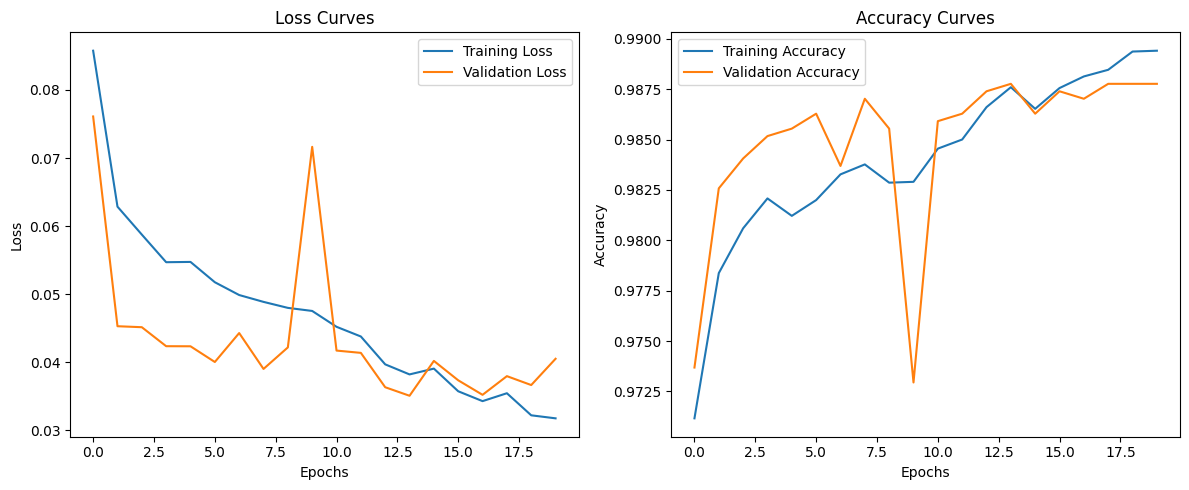

In [20]:
# 19. Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.show()

In [21]:
# 20. Load the best model for testing
model.load_state_dict(torch.load('best-word2vec-model.pt'))

<ipython-input-21-85711f84b253>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-word2vec-model.pt'))


<All keys matched successfully>

In [22]:
# 21. Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.0290 | Test Acc: 99.07%



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3309
           1       0.99      0.99      0.99      3435

    accuracy                           0.99      6744
   macro avg       0.99      0.99      0.99      6744
weighted avg       0.99      0.99      0.99      6744



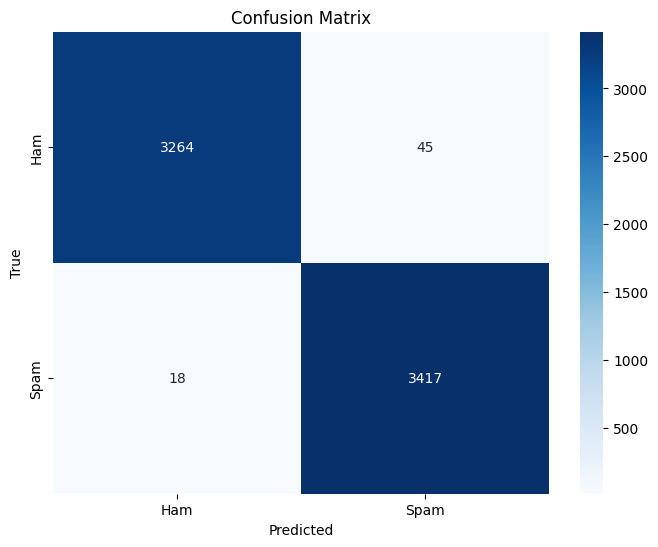

In [23]:
# 22. Generate detailed metrics
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

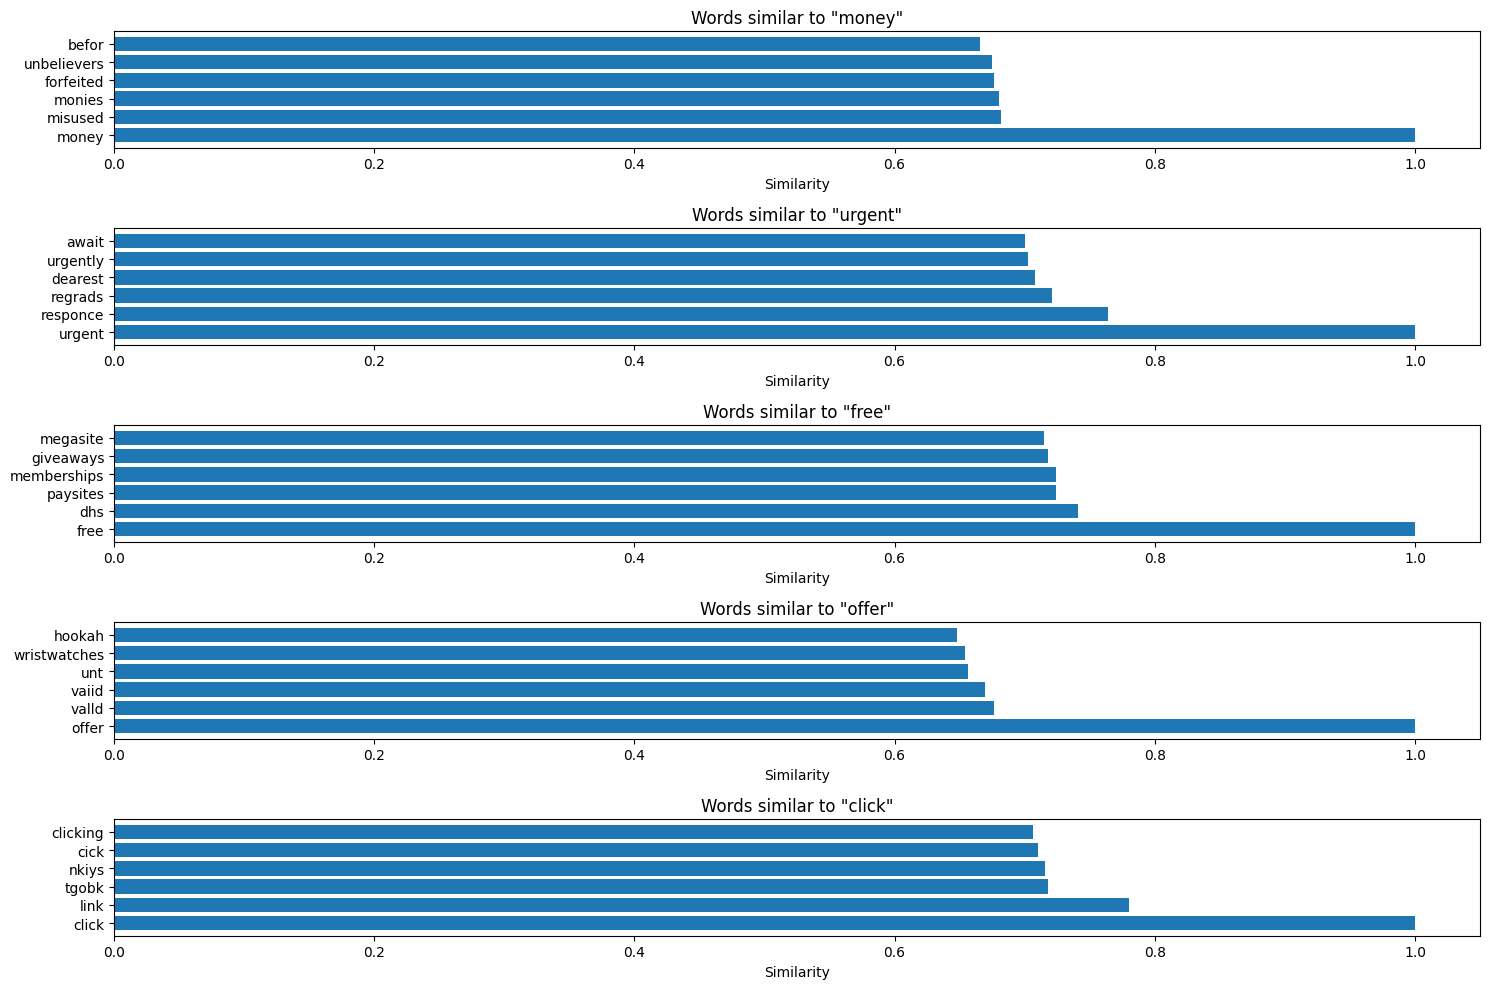

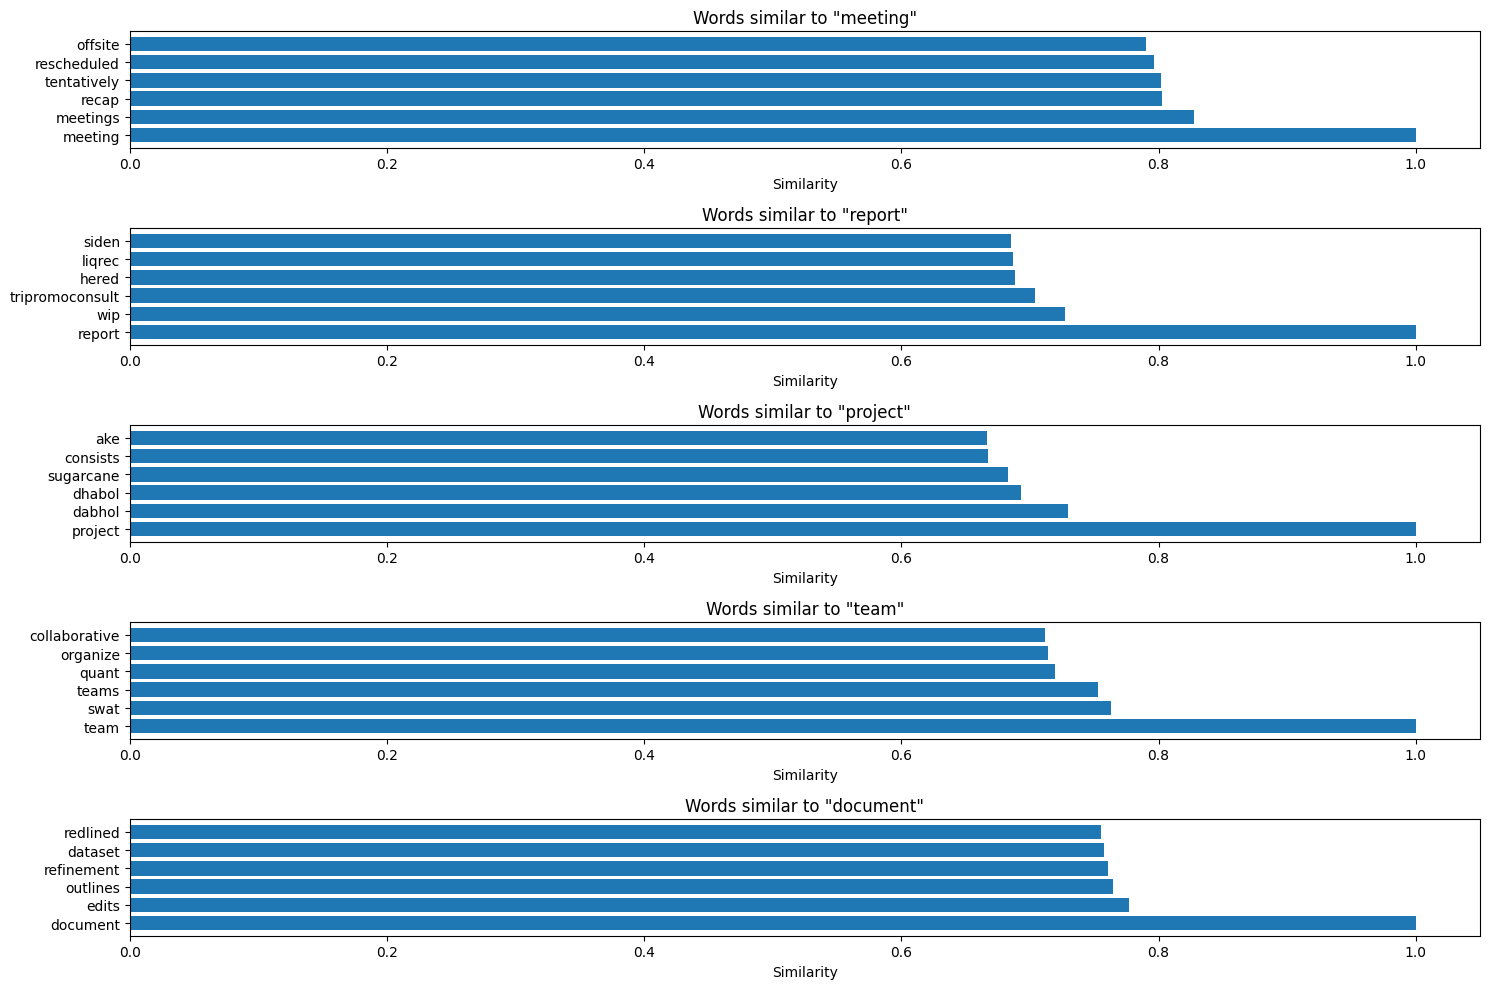

In [24]:
# 23. Visualize Word2Vec word relationships
def plot_word_similarities(model, words, top_n=5):
    """Plot nearest neighbors for selected words"""
    plt.figure(figsize=(15, 10))

    for i, word in enumerate(words):
        if word not in model.wv:
            print(f"Word '{word}' not in vocabulary, skipping...")
            continue

        plt.subplot(len(words), 1, i+1)

        # Get nearest neighbors
        similar_words = model.wv.most_similar(word, topn=top_n)

        # Get similarity scores
        words_list = [word] + [w for w, _ in similar_words]
        similarities = [1.0] + [sim for _, sim in similar_words]

        # Plot bar chart
        plt.barh(range(len(words_list)), similarities, align='center')
        plt.yticks(range(len(words_list)), words_list)
        plt.xlabel('Similarity')
        plt.title(f'Words similar to "{word}"')

    plt.tight_layout()
    plt.show()

# Plot similarity for spam-related and ham-related words
spam_words = ['money', 'urgent', 'free', 'offer', 'click']
plot_word_similarities(w2v_model, spam_words)

ham_words = ['meeting', 'report', 'project', 'team', 'document']
plot_word_similarities(w2v_model, ham_words)

In [25]:
# 24. Save the complete model including Word2Vec model
model_data = {
    'model_state_dict': model.state_dict(),
    'w2v_model_path': 'word2vec_email.model',
}

torch.save(model_data, 'spam_detection_word2vec.pt')
print("Complete model saved to 'spam_detection_word2vec.pt'")

Complete model saved to 'spam_detection_word2vec.pt'


In [26]:
# 25. Function to predict on new emails
def predict_spam_word2vec(emails, model_path='spam_detection_word2vec.pt', w2v_path='word2vec_email.model'):
    # Load models
    model_data = torch.load(model_path)
    w2v_model = Word2Vec.load(w2v_path)

    # Recreate the classifier model
    classifier = Word2VecClassifier(input_dim=EMBEDDING_DIM)
    classifier.load_state_dict(model_data['model_state_dict'])
    classifier.eval()

    # Process the emails
    processed_emails = [preprocess_text(email) for email in emails]
    email_vectors = [document_vector(tokens, w2v_model, EMBEDDING_DIM) for tokens in processed_emails]

    # Convert to tensor
    input_tensor = torch.FloatTensor(email_vectors)

    # Make predictions
    with torch.no_grad():
        outputs = classifier(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)

    # Prepare results
    results = []
    for i, email in enumerate(emails):
        label = "SPAM" if predictions[i].item() == 1 else "HAM"
        confidence = probabilities[i][predictions[i]].item()
        results.append({
            "email": email[:100] + "..." if len(email) > 100 else email,
            "prediction": label,
            "confidence": f"{confidence:.4f}"
        })

    return pd.DataFrame(results)

In [27]:
# 26. Test with example emails
example_emails = [
    "Hello, just checking in about the meeting tomorrow. Let me know if you need anything from me before then.",
    "CONGRATULATIONS! You've WON $10,000,000.00 in our lottery! Send your bank details now to claim your prize!",
    "Please find attached the quarterly report for your review. Let me know if you have any questions.",
    "URGENT: Your account has been compromised. Click here immediately to verify your details and secure your account."
]

prediction_df = predict_spam_word2vec(example_emails)
print("\nPredictions on new emails:")
print(prediction_df)

<ipython-input-26-a80b926ba5e8>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(model_path)



Predictions on new emails:
                                               email prediction confidence
0  Hello, just checking in about the meeting tomo...        HAM     0.9940
1  CONGRATULATIONS! You've WON $10,000,000.00 in ...       SPAM     0.9997
2  Please find attached the quarterly report for ...        HAM     0.9996
3  URGENT: Your account has been compromised. Cli...       SPAM     1.0000


<ipython-input-26-a80b926ba5e8>:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  input_tensor = torch.FloatTensor(email_vectors)


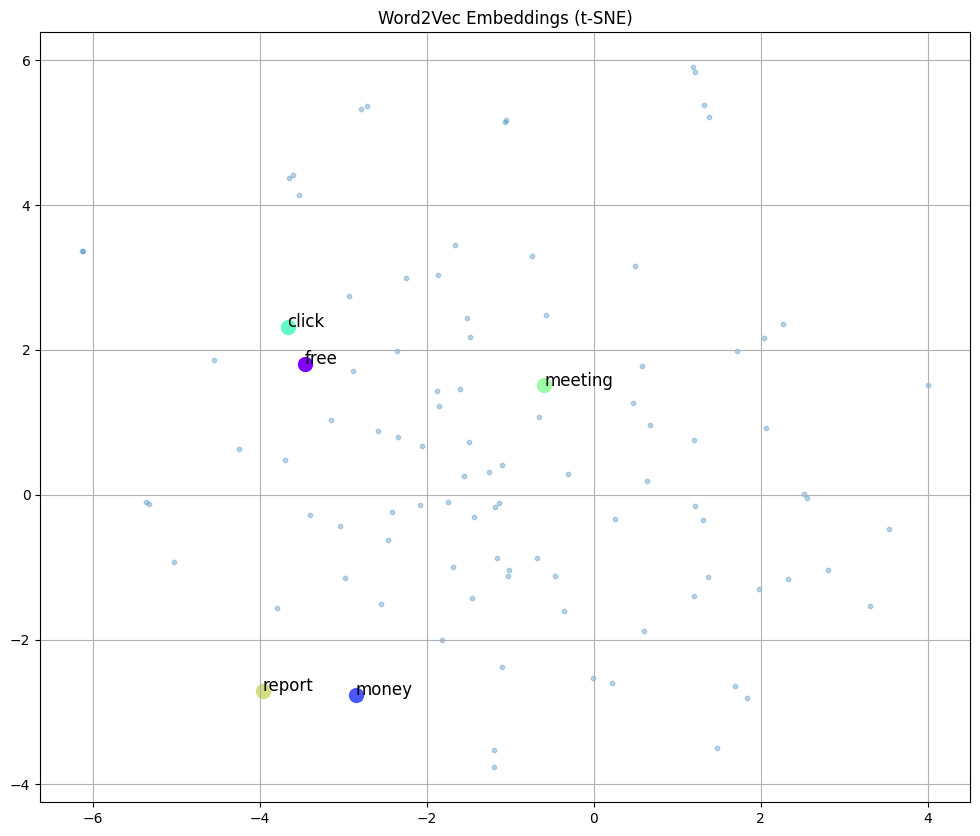

In [31]:
# 27. Visualize Word2Vec embeddings in 2D (t-SNE)
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

def plot_word_embeddings(model, words_to_highlight=None, n_words=100):
    """
    Plot word embeddings in 2D using t-SNE

    Args:
        model: Trained Word2Vec model
        words_to_highlight: List of words to highlight in the plot
        n_words: Number of most frequent words to include in the plot
    """
    # Get word vectors for most common words
    words = list(model.wv.index_to_key[:n_words])
    word_vectors = np.array([model.wv[word] for word in words])  # Convert to numpy array

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, n_words-1))  # Make sure perplexity is valid
    word_vectors_2d = tsne.fit_transform(word_vectors)

    # Plot all words
    plt.figure(figsize=(12, 10))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], s=10, alpha=0.3)

    # If specific words to highlight are provided
    if words_to_highlight:
        # Create a color map
        colors = cm.rainbow(np.linspace(0, 1, len(words_to_highlight)))

        for word, color in zip(words_to_highlight, colors):
            if word in words:
                idx = words.index(word)
                plt.scatter(word_vectors_2d[idx, 0], word_vectors_2d[idx, 1], s=100, alpha=1.0, color=color)
                plt.annotate(word, (word_vectors_2d[idx, 0], word_vectors_2d[idx, 1]), fontsize=12)

    plt.title("Word2Vec Embeddings (t-SNE)")
    plt.grid(True)
    plt.show()

# To use this function:
highlight_words = ['free', 'money', 'urgent', 'offer', 'click', 'meeting', 'report', 'project', 'team', 'document']
plot_word_embeddings(w2v_model, highlight_words)